# Continual Learning Through Synaptic Intelligence

 [(paper)](https://arxiv.org/abs/1703.04200)

In [1]:
import numpy as np
import random
from sklearn.metrics import accuracy_score
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn import Sequential
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from continuum import Rotations
from continuum.datasets import MNIST

In [2]:
def check_cuda():
    """
    Checks if GPU is available.
    """    
    cuda_available = torch.cuda.is_available()
    device = torch.device('cuda' if cuda_available else 'cpu')
    return cuda_available, device

def set_seed(seed=1000):
    """
    Sets the seed for reproducability
    """
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    cuda_available, _ = check_cuda()
    if cuda_available:
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms(True)
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed_all(seed)

In [3]:
def get_cl_metrics(arr):
    """
    Given an array of validation accuracies (each current task along the rows,
    and accuracy of the tasks in the columns), this function computes the 
    CL metrics according to the following paper:
    Don't forget, there is more than forgetting: new metrics for Continual Learning,
    Natalia Díaz-Rodríguez et al. [https://arxiv.org/pdf/1810.13166.pdf]
    
    We are using our own function instead of the Logger from continvvm because of
    a lack of sufficient documentation, and to illustrate how the CL metrics can 
    be computed.
    
    The following metrics are computed:
        - Accuracy,
        - Backward Transfer,
        - BWT+,
        - REM,
        - FWT
        
    Args:
        arr (Numpy array): Array of validation accuracies

    Returns:
        cl_metrics (dict): Dictionary of CL metrics acc, bwt, bwt_plus, rem, fwt
    """

    n = arr.shape[0]

    # Accuracy considers the average accuracy by considering the diagonal 
    # elements as well as all elements below it
    # This is equivalent to computing the sum of the lower traingular matrix
    # and dividing that sum by N(N+1)/2
    acc = np.sum(np.tril(arr))/(n*(n+1)/2.0)

    # Backward transfer (BWT) 
    bwt = 0.0
    for i in range(1, n):
        for j in range(0, i):
            bwt += (arr[i,j] - arr[j,j])
    bwt /= (n*(n-1)/2.0)   

    rem = 1.0 - np.abs(np.min([bwt, 0.0]))
    bwt_plus = np.max([bwt, 0.0])

    # Forward Transfer:  FWT measures the influence that learning a task has 
    # on the performance of future tasks
    # This is the average accuracy for the train-test accuracy entries
    # above the principal diagonal, excluding it 
    # This is equivalent to the sum of the upper tril minus the trace
    fwt = (np.sum(np.triu(arr)) - np.trace(arr))/(n*(n-1)/2.0)

    cl_metrics = {'acc': acc, 'bwt': bwt, 'bwt_plus': bwt_plus, 'rem': rem, 'fwt': fwt}
    return cl_metrics

In [4]:
def get_avg_acc(arr):
    """
    Computes the average accuracies over validation tasks
    
    Args:
        arr (Numpy array): Array of validation accuracies (each current task 
                           along the rows,and accuracy of the tasks in the columns)
                           
    Returns:
        avg_acc_curr_past (Numpy array):
        avg_acc_all (Numpy array):
    """
    
    (nb_tasks, _) = arr.shape
    
    avg_acc_curr_past = np.zeros((nb_tasks,))
    avg_acc_all = np.zeros((nb_tasks,))
    
    for curr_task in range(nb_tasks):
        avg_acc_curr_past[curr_task] = np.mean(arr[curr_task,:curr_task+1])
        avg_acc_all[curr_task] = np.mean(arr[curr_task,:])
        
    return avg_acc_curr_past, avg_acc_all

In [5]:
class SynapticIntelligenceLearner(nn.Module):
    
    def __init__(self, si_c, si_epsilon, lr):
        """
        Initialize the SynapticIntelligenceLearner object.
        Creates the network, sets the SI hyperparameters and
        initializes the buffer objects required for SI updates.
        
        Args:
            si_c (float): Regularization strength parameters
            si_epsilon (float): Damping parameter
            lr (float): Learning rate for optimizer

        """
        super().__init__()
        
        # Set the network
        self.model = Sequential(nn.Linear(784, 2000),
                     nn.ReLU(),
                     nn.Linear(2000,2000),
                     nn.ReLU(),
                     nn.Linear(2000,10))
        
        # Set the SI hyperparameters
        self.si_c = si_c           
        self.si_epsilon = si_epsilon
        
        # Optimizer hyperparameters
        self.lr = lr
        
        # Setting buffers
        # Register starting parameter values
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                n = n.replace('.', '__')
                self.register_buffer(f'{n}_SI_prev_task', p.data.detach().clone())
        
        # Prepare buffers to store running importance estimates
        # and param-values before update
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                n = n.replace('.', '__')
                self.register_buffer(f'W_{n}', p.data.detach().clone().zero_())
                self.register_buffer(f'p_old_{n}', p.data.detach().clone())
                
        # Set the optimizer
        self.reset_optimizer()
                
    def reset_optimizer(self):
        """
        Resets the optimizer
        """
        self.optimizer = optim.Adam(self.model.parameters(), self.lr)     
        
    def update_omega(self):
        """
        Updates the per-parameter importance once training is complete for a task.
        Adapted from https://github.com/GMvandeVen/continual-learning 
        (using buffers instead of Python variables)           
        """
        # Loop over all parameters
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                n = n.replace('.', '__')

                # Calculate new values for quadratic penalty on parameters
                p_prev = getattr(self, f'{n}_SI_prev_task')
                p_current = p.detach().clone()
                p_change = p_current - p_prev
                W_n = getattr(self, f'W_{n}')
                omega_add = W_n/(p_change**2 + self.si_epsilon)
                try:
                    omega = getattr(self, f'{n}_SI_omega')
                except AttributeError:
                    omega = p.detach().clone().zero_()
                omega_new = omega + omega_add

                # Store these new values in the model
                self.register_buffer(f'{n}_SI_prev_task', p_current)
                self.register_buffer(f'{n}_SI_omega', omega_new)

    def surrogate_loss(self):
        """
        Compute the surrogate loss in SI using the per-parameter importance and
        the current and previous parameter values.
        
        Adapted from https://github.com/GMvandeVen/continual-learning 
        (using buffers instead of Python variables)
        """
        try:
            losses = []
            for n, p in self.model.named_parameters():
                if p.requires_grad:
                    # Retrieve previous parameter values and their normalized path integral (i.e., omega)
                    n = n.replace('.', '__')
                    prev_values = getattr(self, f'{n}_SI_prev_task')
                    omega = getattr(self, f'{n}_SI_omega')
                    # Calculate SI's surrogate loss, sum over all parameters
                    losses.append((omega * (p-prev_values)**2).sum())
            return sum(losses)
        except AttributeError:
            # SI-loss is 0 if there is no stored omega yet
            return torch.tensor(0.)
        
    def train_step(self, x, y, t):
        """
        Single batch of training
        
        Args:
            x (torch tensor): Batch of inputs
            y (torch tensor): Batch of labels
            t (torch tensor): Batch of task ids
        """
        
        # Zero the parameter gradients
        self.optimizer.zero_grad()

        # Perform a forward pass and compute the cross entropy loss
        x = torch.flatten(x, 1)
        y_hat = self.model(x)
        loss = F.cross_entropy(input=y_hat, target=y, reduction='mean')
        
        # Compute the SI surrogate loss
        surrogate_loss = self.surrogate_loss()
        loss += self.si_c * surrogate_loss
        
        # Backprop and gradient step
        loss.backward()
        self.optimizer.step()

        # Compute the training accuracy
        pred = torch.argmax(y_hat, dim=-1)
        acc = accuracy_score(y.detach().cpu().numpy(), pred.detach().cpu().numpy(), normalize=True)
        
        # Update W (running importance estimate) after each batch
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                n = n.replace('.', '__')
                if p.grad is not None:
                    W_n = getattr(self, f'W_{n}')
                    p_old_n = getattr(self, f'p_old_{n}')
                    W_n.add_(-p.grad*(p.detach()-p_old_n))
                    self.register_buffer(f'W_{n}', W_n)
                p_old_n = p.detach().clone()
                self.register_buffer(f'p_old_{n}', p_old_n)
                
        # Return the training accuracy
        return acc
            
    def val_step(self, x, y, t):
        """
        Single batch of validation
        
        Args:
            x (torch tensor): Batch of inputs
            y (torch tensor): Batch of labels
            t (torch tensor): Batch of task ids
        """
                
        with torch.no_grad():
            
            # Forward pass
            x = torch.flatten(x, 1)
            y_hat = self.model(x)
            
            # Compute the validation accuracy
            pred = torch.argmax(y_hat, dim=-1)
            acc = accuracy_score(y.detach().cpu().numpy(), pred.detach().cpu().numpy(), normalize=True)
            
        return acc
    

In [6]:
def train_val(si_model, list_degrees, train_dataset, val_dataset, num_epochs, batch_size, device='cpu'):
    """
    Complete training and validation loop over all tasks.
    
    Once training is complete for a task, validation is performed using the validation
    datasets of all past, current and future tasks. This is needed for computing the 
    CL metrics.
    
    Args:
        si_model (SynapticIntelligenceLearner): The learner class
        list_degrees (list): List of angles in degrees for the RotatedMNIST tasks
        train_dataset (MNIST): Training MNIST Dataset object 
        val_dataset (MNIST): Validation MNIST Dataset object 
        num_epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        device (str): Device to use for training ('cpu' or 'cuda')
        
    Returns:
        val_acc_arr (Numpy array): Array of validation accuracies (each current task 
                                   along the rows,and accuracy of the tasks in the columns)
    """

    nb_tasks = len(list_degrees)

    # Array to store validation accuracies (each current task along the rows,
    # and accuracy of the tasks in the columns)
    val_acc_arr = np.zeros((nb_tasks, nb_tasks))

    train_scenario = Rotations(cl_dataset=train_dataset,
                               nb_tasks=nb_tasks,
                               list_degrees=list_degrees)

    val_scenario = Rotations(cl_dataset=val_dataset,
                             nb_tasks=nb_tasks,
                             list_degrees=list_degrees)

    for task_id, train_taskset in enumerate(train_scenario):

        print(f'Starting task_id: {task_id}')

        # Reset the optimizer at the start of each task
        # si_model.reset_optimizer()  # Not done for permuted MNIST in the paper

        train_loader = DataLoader(train_taskset, batch_size=batch_size, shuffle=True)

        for epoch in range(num_epochs):
            
            print(f'Starting epoch: {epoch}')
            
            si_model.train()

            train_accuracies = list()

            for x, y, t in tqdm(train_loader):
                train_accuracies.append(si_model.train_step(x.to(device), y.to(device), t.to(device)))

            train_acc = np.mean(train_accuracies)

            print(f'task_id: {task_id}, epoch: {epoch}, train_accuracy: {train_acc}')

        # Update omega on ending a task
        si_model.update_omega()

        # At the end of the epoch validate on all tasks (past, current, and future tasks)
        si_model.eval()
        for val_task_id, val_taskset in enumerate(val_scenario):
            val_loader = DataLoader(val_taskset, batch_size=1, shuffle=False)
            val_accuracies = list()

            for x, y, t in val_loader:
                val_accuracies.append(si_model.val_step(x.to(device), y.to(device), t.to(device)))

            val_acc = np.mean(val_accuracies)

            val_acc_arr[task_id][val_task_id] = val_acc

            print(f'Current task: {task_id}, Validating on task: {val_task_id}, Accuracy: {val_acc}')
            
    return val_acc_arr

In [7]:
# Setting hyperparameters
NUM_EPOCHS = 5  # instead of 20 (in the paper)
SI_C = 0.1
SI_EPSILON = 0.1
LEARNING_RATE = 0.001
BATCH_SIZE = 256

In [8]:
# Check if CUDA is available
cuda_available, device = check_cuda()
print(f'cuda_available: {cuda_available}, device: {device}')

cuda_available: False, device: cpu


In [9]:
# Create the Dataset objects
list_degrees = [0, 45, 90, 135, 180]
train_dataset = MNIST(data_path="dataset", download=True, train=True)
val_dataset = MNIST(data_path="dataset", download=True, train=False)

In [10]:
set_seed()

# Create the learner object
si_model = SynapticIntelligenceLearner(si_c=SI_C, si_epsilon=SI_EPSILON, lr=LEARNING_RATE)
si_model = si_model.to(device)

In [11]:
# Train using SI
val_acc_arr = train_val(si_model=si_model, 
                        list_degrees=list_degrees, 
                        train_dataset=train_dataset, 
                        val_dataset=val_dataset,
                        num_epochs=NUM_EPOCHS, 
                        batch_size=BATCH_SIZE)

Starting task_id: 0
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 0, train_accuracy: 0.9314937943262412
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 1, train_accuracy: 0.976346409574468
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 2, train_accuracy: 0.9847850177304965
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 3, train_accuracy: 0.9884363918439716
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 4, train_accuracy: 0.9900487588652481
Current task: 0, Validating on task: 0, Accuracy: 0.9825
Current task: 0, Validating on task: 1, Accuracy: 0.3708
Current task: 0, Validating on task: 2, Accuracy: 0.1486
Current task: 0, Validating on task: 3, Accuracy: 0.2157
Current task: 0, Validating on task: 4, Accuracy: 0.3265
Starting task_id: 1
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 0, train_accuracy: 0.9473847517730497
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 1, train_accuracy: 0.9819315159574468
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 2, train_accuracy: 0.9881538120567375
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 3, train_accuracy: 0.9922872340425531
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 4, train_accuracy: 0.9940492021276596
Current task: 1, Validating on task: 0, Accuracy: 0.7577
Current task: 1, Validating on task: 1, Accuracy: 0.9812
Current task: 1, Validating on task: 2, Accuracy: 0.3958
Current task: 1, Validating on task: 3, Accuracy: 0.1306
Current task: 1, Validating on task: 4, Accuracy: 0.2807
Starting task_id: 2
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 0, train_accuracy: 0.9505817819148936
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 1, train_accuracy: 0.9836103723404256
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 2, train_accuracy: 0.9901318705673758
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 3, train_accuracy: 0.9930518617021277
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 4, train_accuracy: 0.9943317819148936
Current task: 2, Validating on task: 0, Accuracy: 0.3277
Current task: 2, Validating on task: 1, Accuracy: 0.802
Current task: 2, Validating on task: 2, Accuracy: 0.9798
Current task: 2, Validating on task: 3, Accuracy: 0.3932
Current task: 2, Validating on task: 4, Accuracy: 0.1741
Starting task_id: 3
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 0, train_accuracy: 0.9517453457446808
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 1, train_accuracy: 0.9832668439716311
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 2, train_accuracy: 0.9891511524822694
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 3, train_accuracy: 0.9910294769503545
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 4, train_accuracy: 0.993500664893617
Current task: 3, Validating on task: 0, Accuracy: 0.3321
Current task: 3, Validating on task: 1, Accuracy: 0.4971
Current task: 3, Validating on task: 2, Accuracy: 0.8476
Current task: 3, Validating on task: 3, Accuracy: 0.9838
Current task: 3, Validating on task: 4, Accuracy: 0.445
Starting task_id: 4
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 0, train_accuracy: 0.9579953457446808
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 1, train_accuracy: 0.9842309397163119
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 2, train_accuracy: 0.988984929078014
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 3, train_accuracy: 0.9918550531914894
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 4, train_accuracy: 0.9917331560283689
Current task: 4, Validating on task: 0, Accuracy: 0.3839
Current task: 4, Validating on task: 1, Accuracy: 0.3922
Current task: 4, Validating on task: 2, Accuracy: 0.5494
Current task: 4, Validating on task: 3, Accuracy: 0.8507
Current task: 4, Validating on task: 4, Accuracy: 0.9803


In [12]:
# Compute the CL metrics
cl_metrics = get_cl_metrics(val_acc_arr)

# Compute the average accuracy (over other tasks) for each current task
avg_acc_curr_past, avg_acc_all = get_avg_acc(val_acc_arr)

In [13]:
set_seed()

# Train another model without any continual learning
si_model_no_cl = SynapticIntelligenceLearner(si_c=0.0, si_epsilon=SI_EPSILON, lr=LEARNING_RATE)
val_acc_arr_no_cl = train_val(si_model_no_cl, 
                              list_degrees=list_degrees, 
                              train_dataset=train_dataset, 
                              val_dataset=val_dataset,
                              num_epochs=NUM_EPOCHS, 
                              batch_size=BATCH_SIZE)

Starting task_id: 0
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 0, train_accuracy: 0.9314937943262412
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 1, train_accuracy: 0.976346409574468
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 2, train_accuracy: 0.9847850177304965
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 3, train_accuracy: 0.9884363918439716
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 0, epoch: 4, train_accuracy: 0.9900487588652481
Current task: 0, Validating on task: 0, Accuracy: 0.9825
Current task: 0, Validating on task: 1, Accuracy: 0.3708
Current task: 0, Validating on task: 2, Accuracy: 0.1486
Current task: 0, Validating on task: 3, Accuracy: 0.2157
Current task: 0, Validating on task: 4, Accuracy: 0.3265
Starting task_id: 1
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 0, train_accuracy: 0.9472019060283688
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 1, train_accuracy: 0.9817929964539008
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 2, train_accuracy: 0.9887688386524822
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 3, train_accuracy: 0.9927859042553191
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 1, epoch: 4, train_accuracy: 0.9950797872340426
Current task: 1, Validating on task: 0, Accuracy: 0.7328
Current task: 1, Validating on task: 1, Accuracy: 0.9774
Current task: 1, Validating on task: 2, Accuracy: 0.4008
Current task: 1, Validating on task: 3, Accuracy: 0.138
Current task: 1, Validating on task: 4, Accuracy: 0.2925
Starting task_id: 2
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 0, train_accuracy: 0.9495955230496455
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 1, train_accuracy: 0.9846409574468085
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 2, train_accuracy: 0.9916167996453902
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 3, train_accuracy: 0.9945589539007093
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 2, epoch: 4, train_accuracy: 0.9963264627659575
Current task: 2, Validating on task: 0, Accuracy: 0.2423
Current task: 2, Validating on task: 1, Accuracy: 0.7394
Current task: 2, Validating on task: 2, Accuracy: 0.98
Current task: 2, Validating on task: 3, Accuracy: 0.4153
Current task: 2, Validating on task: 4, Accuracy: 0.1601
Starting task_id: 3
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 0, train_accuracy: 0.9509197695035461
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 1, train_accuracy: 0.9839982269503545
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 2, train_accuracy: 0.990979609929078
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 3, train_accuracy: 0.9946199024822694
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 3, epoch: 4, train_accuracy: 0.996309840425532
Current task: 3, Validating on task: 0, Accuracy: 0.2724
Current task: 3, Validating on task: 1, Accuracy: 0.2554
Current task: 3, Validating on task: 2, Accuracy: 0.7528
Current task: 3, Validating on task: 3, Accuracy: 0.9842
Current task: 3, Validating on task: 4, Accuracy: 0.4501
Starting task_id: 4
Starting epoch: 0


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 0, train_accuracy: 0.9544437056737588
Starting epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 1, train_accuracy: 0.9862089982269503
Starting epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 2, train_accuracy: 0.9921043882978723
Starting epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 3, train_accuracy: 0.9961602393617022
Starting epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

task_id: 4, epoch: 4, train_accuracy: 0.9975398936170212
Current task: 4, Validating on task: 0, Accuracy: 0.3669
Current task: 4, Validating on task: 1, Accuracy: 0.2846
Current task: 4, Validating on task: 2, Accuracy: 0.333
Current task: 4, Validating on task: 3, Accuracy: 0.7947
Current task: 4, Validating on task: 4, Accuracy: 0.9855


In [14]:
# Compute the CL metrics
cl_metrics_no_cl = get_cl_metrics(val_acc_arr_no_cl)

# Compute the average accuracy (over other tasks) for each current task
avg_acc_curr_past_no_cl, avg_acc_all_no_cl = get_avg_acc(val_acc_arr_no_cl)

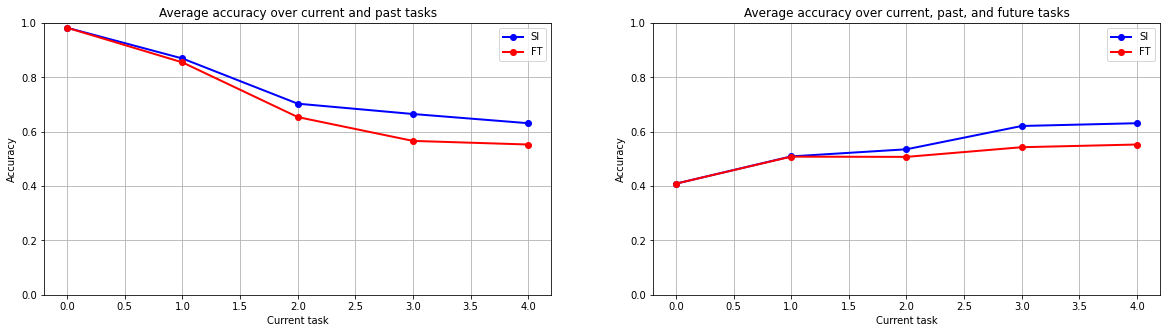

In [15]:
# Compare the results

# Line plots for average accuracy

fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].plot(avg_acc_curr_past, lw=2, color='blue', marker='o', label='SI')
ax[0].plot(avg_acc_curr_past_no_cl, lw=2, color='red', marker='o', label='FT')

ax[1].plot(avg_acc_all, lw=2, color='blue', marker='o', label='SI')
ax[1].plot(avg_acc_all_no_cl, lw=2, color='red', marker='o', label='FT')

ax[0].set_title("Average accuracy over current and past tasks")
ax[1].set_title("Average accuracy over current, past, and future tasks")
for a in ax:
    a.set_xlabel("Current task")
    a.set_ylabel("Accuracy")
    a.set_ylim([0.0,1.0])
    a.grid(True)
    a.legend()

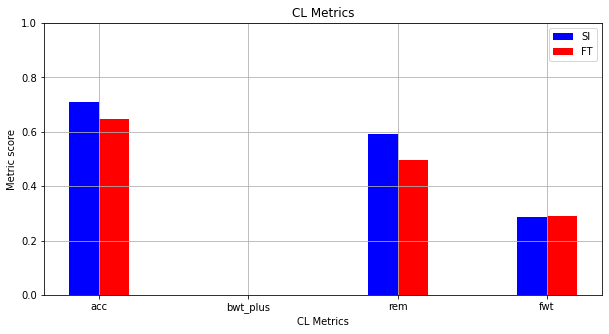

In [16]:
# Bar plots for CL metrics

fig, ax = plt.subplots(1,1,figsize=(10,5))
width = 0.2

ax.bar(np.arange(4)-width/2.0, 
      (cl_metrics['acc'], cl_metrics['bwt_plus'], cl_metrics['rem'], cl_metrics['fwt']), 
       width=width, 
       label='SI',
       color='blue')
ax.bar(np.arange(4)+width/2.0, 
      (cl_metrics_no_cl['acc'], cl_metrics_no_cl['bwt_plus'], cl_metrics_no_cl['rem'], cl_metrics_no_cl['fwt']), 
       width=width, 
       label='FT',
       color='red')

ax.grid(True)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['acc', 'bwt_plus', 'rem', 'fwt'])
ax.set_xlabel('CL Metrics')
ax.set_ylabel('Metric score')
ax.set_ylim([0.0, 1.0])
ax.legend()
_ = ax.set_title('CL Metrics')